In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os

2025-05-28 21:42:45.343984: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 21:42:45.376064: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 21:42:45.965760: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 21:42:46.263984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748468566.657464    1555 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748468566.73

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
from tensorflow.keras.mixed_precision import Policy
policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [4]:
# CIFAR-100 class names (got from website)
class_names = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle",
    "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle",
    "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur",
    "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard",
    "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain",
    "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree",
    "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket",
    "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor",
    "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
]

In [5]:
# This is to load the data from the tensorflow dataset cifar 100
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
num_classes = len(np.unique(y_train))
print(X_train.shape, X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


array pointer = 12
image shape: (32, 32, 3)
Class label: 82


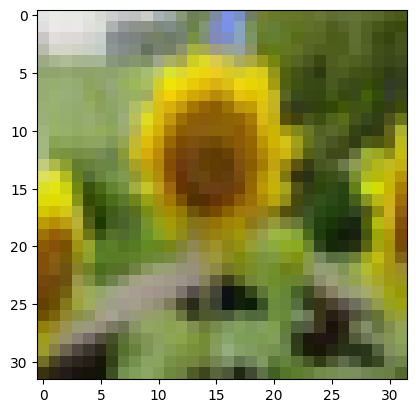

In [6]:
#check one image to see what it looks like and randomly 
# we picked index 12 to test.
imageindex = 12
print(f"array pointer = {imageindex}")
print(f"image shape: {X_train[imageindex].shape}")
print(f"Class label: {y_train[imageindex][0]}") # [0] since it is a 2D array

#this prints the image and shows it on a graph
plt.imshow(X_train[imageindex],cmap='viridis')
plt.show()

In [7]:
def check_pics(data, dataset_name):
    """
    Check CIFAR-100 images for:
    - Array type
    - Shape (32x32x3)
    - Pixel values (0-255)
    - No NaNs
    """
    bad_imgs = 0
    good_imgs = 0
    for i, img in enumerate(data):
        if not isinstance(img, np.ndarray):
            print(f"{dataset_name} img {i}: Not an array")
            bad_imgs += 1
            continue
        if img.shape != (32, 32, 3):
            print(f"{dataset_name} img {i}: Shape {img.shape}, need (32, 32, 3)")
            bad_imgs += 1
            continue
        if not (img.dtype == np.uint8 and img.min() >= 0 and img.max() <= 255):
            print(f"{dataset_name} img {i}: Bad pixels, min={img.min()}, max={img.max()}")
            bad_imgs += 1
            continue
        if np.isnan(img).any():
            print(f"{dataset_name} img {i}: NaN found")
            bad_imgs += 1
            continue
        good_imgs += 1
    print(f"{dataset_name}: {good_imgs} good, {bad_imgs} bad")

print("Checking images...\n")
check_pics(X_train, "Train")
check_pics(X_test, "Test")

Checking images...

Train: 50000 good, 0 bad
Test: 10000 good, 0 bad


In [8]:
# spliting the data into the train and validate it (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=15
)

#checking to see if the shapes are the same 
print("Training set:", X_train.shape, y_train.shape)
print("Validating set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (40000, 32, 32, 3) (40000, 1)
Validating set: (10000, 32, 32, 3) (10000, 1)
Test set: (10000, 32, 32, 3) (10000, 1)


In [9]:
# Normalising pixels to 0-1
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [10]:
# One-hot encode labels
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [11]:
counts = pd.DataFrame(columns=['Set', 'Class', 'Count'])
def count_cls(data, name):
    global counts
    cls, nums = np.unique(np.argmax(data, axis=1) if data.ndim > 1 else data, return_counts=True)
    for c, n in zip(cls, nums):
        counts = pd.concat([counts, pd.DataFrame([{'Set': name, 'Class': str(c), 'Count': n}])], ignore_index=True)

count_cls(y_train, "Train")
count_cls(y_val, "Val")
count_cls(y_test, "Test")

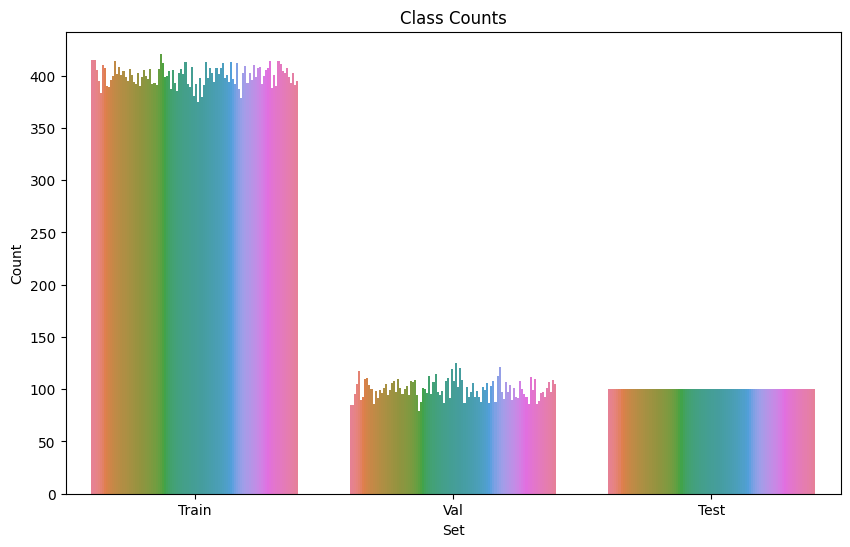

In [12]:
# Plot class counts
plt.figure(figsize=(10, 6))
sns.barplot(data=counts, x='Set', y='Count', hue='Class')
plt.title("Class Counts")
plt.legend([], [], frameon=False)  # Too many classes

In [13]:
# Model 1: Very Lightweight CNN
# Super simple to train fast
def light_cnn(shape, classes):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=shape, padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn1 = light_cnn((32, 32, 3), num_classes)
cnn1.summary()

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-28 21:43:18.727128: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,724 (557.52 KB)

 Trainable params: 142,724 (557.52 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train with bigger batch size
stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Use tf.data for faster loading
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(128).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(128).prefetch(tf.data.AUTOTUNE)

print("Training Light CNN...")
cnn1_hist = cnn1.fit(
    train_data,
    epochs=20,  # Less epochs to be quick
    validation_data=val_data,
    callbacks=[stop]
)

Training Light CNN...
Epoch 1/20


2025-05-28 21:43:24.034322: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


313/313 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.0375 - loss: 4.3993 - val_accuracy: 0.1379 - val_loss: 3.7296
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.1561 - loss: 3.6127 - val_accuracy: 0.1947 - val_loss: 3.3978
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 465s 1s/step - accuracy: 0.2087 - loss: 3.2997 - val_accuracy: 0.2252 - val_loss: 3.2211
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.2477 - loss: 3.0934 - val_accuracy: 0.2489 - val_loss: 3.0710
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.2718 - loss: 2.9434 - val_accuracy: 0.2684 - val_loss: 3.0197
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.2939 - loss: 2.8449 - val_accuracy: 0.2882 - val_loss: 2.9048
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.3161 - loss: 2.7342 - val_accuracy: 0.2887 - val_loss: 2.8847
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.3241 - loss: 2.6806 - val_accuracy: 0.309

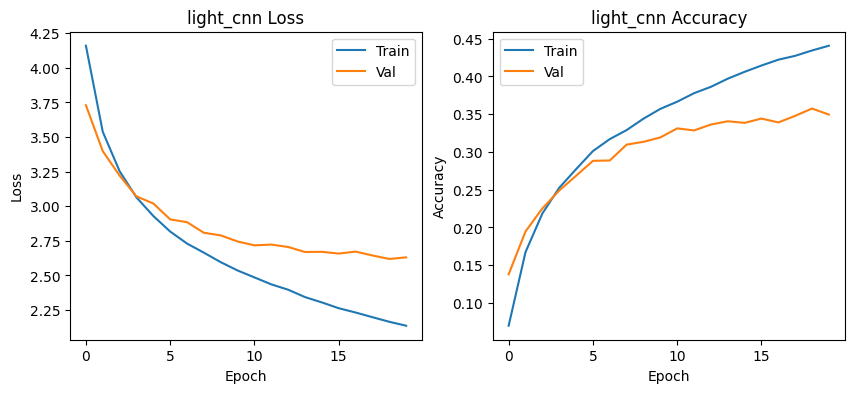

In [15]:
# Plot training
def plot_training(hist, name):
    df = pd.DataFrame(hist.history)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df['loss'], label='Train')
    plt.plot(df['val_loss'], label='Val')
    plt.title(f'{name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(df['accuracy'], label='Train')
    plt.plot(df['val_accuracy'], label='Val')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


plot_training(cnn1_hist, "light_cnn")

In [16]:

# Test models
cnn1_loss, cnn1_acc = cnn1.evaluate(X_test, y_test)
print(f"Light CNN: Loss = {cnn1_loss:.4f}, Acc = {cnn1_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3493 - loss: 2.6199
Light CNN: Loss = 2.6213, Acc = 0.3509


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

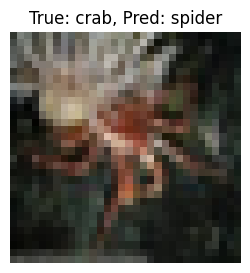

In [17]:
# Predict
idx = 100
img = X_test[idx:idx+1]
true = np.argmax(y_test[idx])
probs = cnn1.predict(img)
pred = np.argmax(probs)

plt.figure(figsize=(3, 3))
plt.imshow(img[0])
plt.title(f"True: {class_names[true]}, Pred: {class_names[pred]}")
plt.axis('off')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'apple'),
  Text(1, 0, 'aquarium_fish'),
  Text(2, 0, 'baby'),
  Text(3, 0, 'bear'),
  Text(4, 0, 'beaver'),
  Text(5, 0, 'bed'),
  Text(6, 0, 'bee'),
  Text(7, 0, 'beetle'),
  Text(8, 0, 'bicycle'),
  Text(9, 0, 'bottle')])

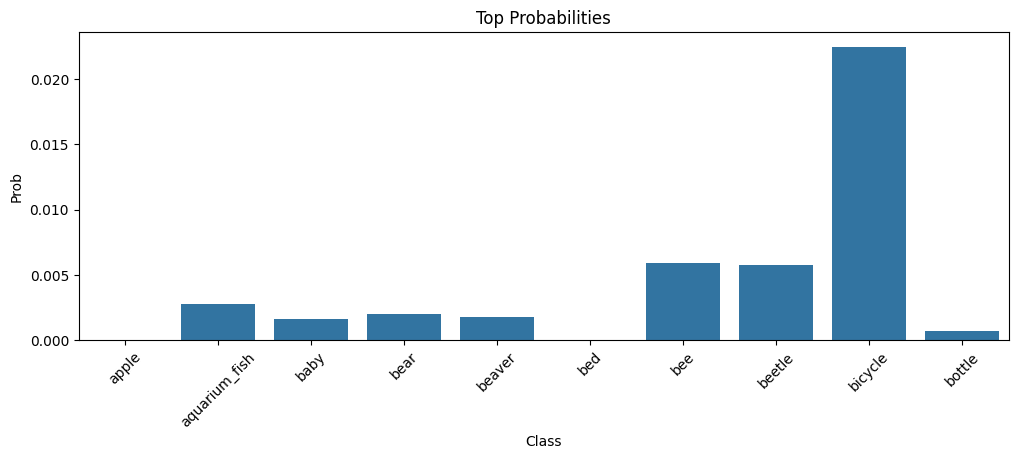

In [18]:
# Probabilities (top 10)
prob_df = pd.DataFrame(probs[0], columns=['Prob'])
prob_df['Class'] = class_names
plt.figure(figsize=(12, 4))
sns.barplot(data=prob_df.head(10), x='Class', y='Prob')
plt.title('Top Probabilities')
plt.xticks(rotation=45)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Confusion Matrix (rows/cols are class names):
               apple  aquarium_fish  baby  bear  beaver  bed  bee  beetle  \
apple             65              3     0     0       0    0    0       1   
aquarium_fish      1             42     2     0       0    0    0       0   
baby               4              2    32     0       0    4    0       0   
bear               0              0     1    15       6    0    1       0   
beaver             0              1     1     3      14    1    0       3   
...              ...            ...   ...   ...     ...  ...  ...     ...   
whale              0              0     0     1       0    0    0       0   
willow_tree        0              0     1     0       0    0    0       0   
wolf               0              0     0     0       1    0    0       0   
woman              0              2     9     0       0    2    0       0   
worm               3              1     2     0       0    1    0

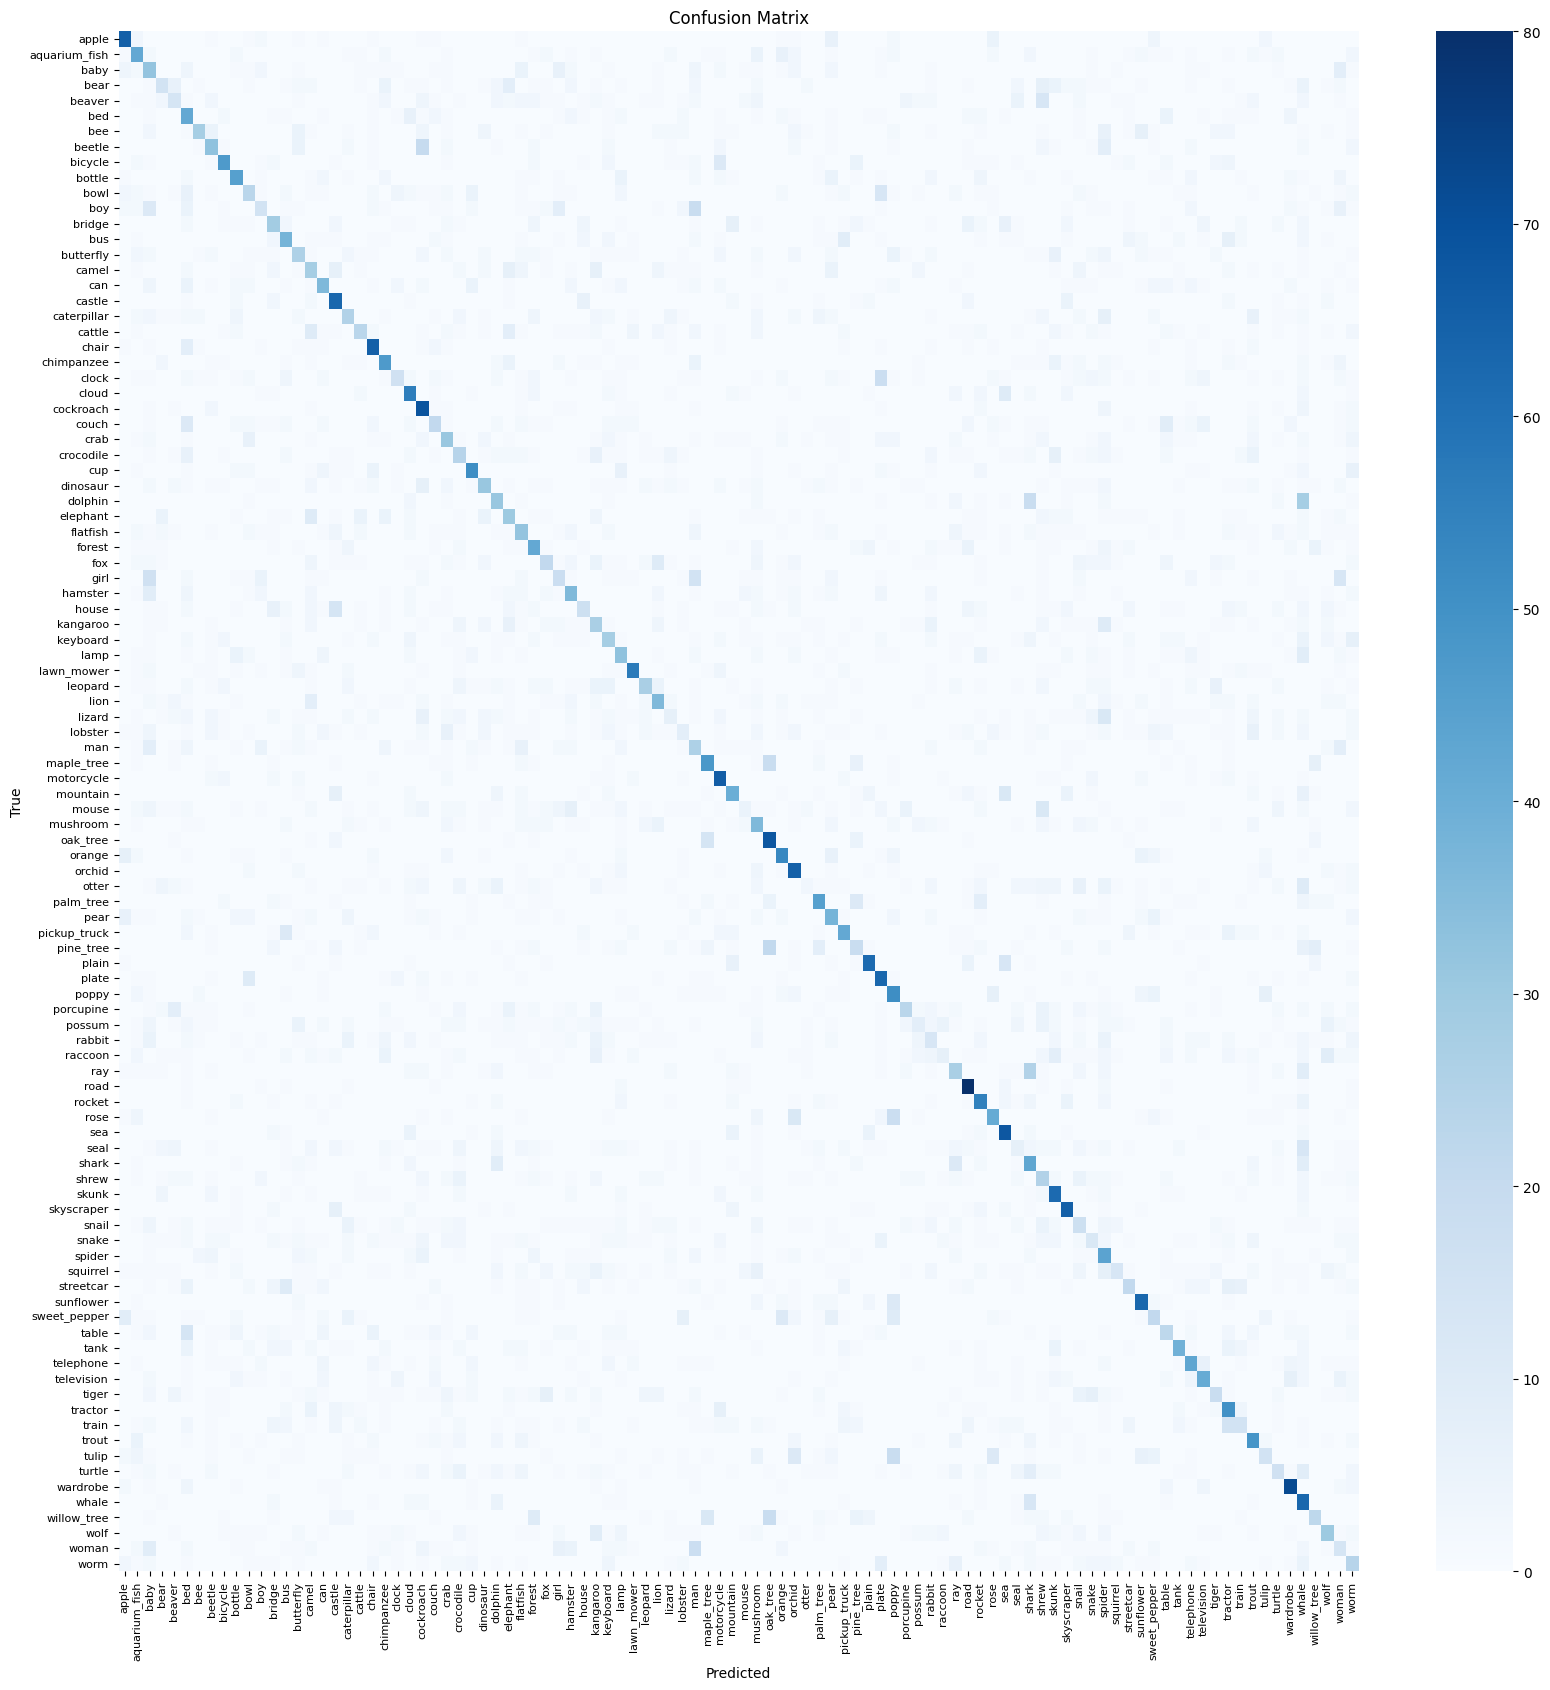

In [19]:
# Results
def show_results(data, labels, model):
    preds = np.argmax(model.predict(data), axis=1)
    true = np.argmax(labels, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(true, preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 20))  # Big plot for 100 classes
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    
    # Print confusion matrix
    print("Confusion Matrix (rows/cols are class names):")
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    print(cm_df)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(true, preds, target_names=class_names))

show_results(X_test, y_test, cnn1)